**Описание проекта**
1. Интернет-магазину (продажа компьютерных игр по всему миру) необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
2. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

## Изучение и знакомство с данными

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import levene

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
df=pd.read_csv('/datasets/games.csv')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


- Сразу бросается в глаза не полные данные по оценкам критиков, пользователей и рейтингу;
- Для года релиза необходим тип данных int, а оценка пользователей явно в цифровом формате, а не в объектном;
- Названия столбцов приведем к нижнему регистру.

### Вывод<a id="result1"></a>
1. Проверим каждый столбец на наличие пропусков и артефактов;
2. Проверим дубликаты;
3. Поменяем тип данных.

## Подготовка данных для анализа

In [ ]:
# Поменяем названия столбцов
df.columns = df.columns.str.lower()
# df.head() 

1. Предобработка `name`

In [ ]:
df[df['name'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.00,NaN,1.78,0.53,0.00,0.08,nan,NaN,NaN
14244,NaN,GEN,1993.00,NaN,0.00,0.00,0.03,0.00,nan,NaN,NaN


In [ ]:
df.dropna(subset=['name'], inplace=True)
# проверка df[df['name'].isna()].head()

2. Предобработка `year_of_release`

In [ ]:
# Поменяем тип данных
df['year_of_release'] = df['year_of_release'].round(0).astype('Int64')
# Проверим пропуски
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.00,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.00,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.00,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,nan,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,nan,NaN,NaN


In [ ]:
# Предположим, что игры вышли на разных платформах в один год (используем first())
mapper = df.groupby("name")['year_of_release'].first().to_dict()
 
def year_release(row):
    if np.isnan(row['year_of_release']):
        return mapper.get((row["name"]))
    return row['year_of_release']
 
df['year_of_release'] = df.apply(year_release, axis=1)
# проверка df['year_of_release'].isna().sum()

In [ ]:
# Попробуем вычленить года в названии игры и заменим ими NaN
def year_rel(row):
    for word in row.split():
        if word.isnumeric():
            return int(word)
def year_release2(row):
    if np.isnan(row['year_of_release']):
        return year_rel(row['name'])
    return row['year_of_release']
df['year_of_release'] = df.apply(year_release2, axis=1)
df['year_of_release'].isna().sum()

124

In [ ]:
# проверим, нет ли у нас нестандартных годов,
# вдруг в выборке был GTA 4, и тогда год будет 4
df['year_of_release'].value_counts()

2008.00    1441
2009.00    1430
2010.00    1269
2007.00    1203
2011.00    1154
2006.00    1021
2005.00     949
2002.00     845
2003.00     784
2004.00     764
2012.00     662
2015.00     606
2014.00     581
2013.00     548
2016.00     502
2001.00     486
1998.00     380
2000.00     351
1999.00     339
1997.00     289
1996.00     263
1995.00     219
1994.00     122
1993.00      60
1981.00      46
1992.00      43
1991.00      42
1982.00      36
1986.00      21
1989.00      17
1983.00      17
1990.00      16
1987.00      16
1988.00      15
1985.00      14
1984.00      14
1980.00       9
2.00          8
99.00         2
3.00          2
500.00        1
64.00         1
4.00          1
Name: year_of_release, dtype: int64

In [ ]:
# Ошибки чистки данных
display(df[df['year_of_release'] == 2])
display(df[df['year_of_release'] == 99])
display(df[df['year_of_release'] == 3])
display(df[df['year_of_release'] == 500])
display(df[df['year_of_release'] == 64])
display(df[df['year_of_release'] == 4])
# моего внимания заслужил только TDU2 and Yakuza 4,
# у них заменим года из интернета, остальные вернем в NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2969,Test Drive Unlimited 2,X360,2.00,Racing,0.30,0.31,0.00,0.07,68.00,6.4,T
3187,Monster Hunter 2,PS2,2.00,Role-Playing,0.00,0.00,0.63,0.00,nan,NaN,NaN
3233,Test Drive Unlimited 2,PS3,2.00,Racing,0.16,0.34,0.01,0.12,70.00,6.1,T
5294,Dragon Ball Z: Budokai Tenkaichi 2 (JP sales),Wii,2.00,Action,0.15,0.05,0.14,0.01,nan,NaN,NaN
7108,Big Beach Sports 2,Wii,2.00,Sports,0.09,0.11,0.00,0.02,nan,tbd,E
7735,Test Drive Unlimited 2,PC,2.00,Racing,0.05,0.11,0.00,0.03,72.00,5.7,T
10764,Luminous Arc 2 (JP sales),DS,2.00,Role-Playing,0.00,0.00,0.10,0.00,nan,NaN,NaN
14105,Half-Minute Hero 2,PSP,2.00,Role-Playing,0.00,0.00,0.04,0.00,nan,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1301,Triple Play 99,PS,99.00,Sports,0.81,0.55,0.00,0.10,nan,NaN,NaN
12046,Drake of the 99 Dragons,XB,99.00,Shooter,0.05,0.01,0.00,0.00,22.00,1.8,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11925,Port Royale 3,PS3,3.00,Simulation,0.06,0.00,0.00,0.01,nan,8.9,T
12221,Port Royale 3,X360,3.00,Simulation,0.06,0.00,0.00,0.01,56.00,4.5,T


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6266,Indy 500,2600,500.00,Racing,0.26,0.01,0.00,0.00,nan,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7605,Famista 64,N64,64.00,Sports,0.00,0.00,0.17,0.03,nan,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2169,Yakuza 4,PS3,4.00,Action,0.15,0.13,0.63,0.05,78.00,8,M


In [ ]:
def tdu2(row):
    if row['name'] == 'Test Drive Unlimited 2':
        return 2011
    if row['name'] == 'Yakuza 4':
        return 2010
    return row['year_of_release']
df['year_of_release'] = df.apply(tdu2, axis=1)
# display(df[df['year_of_release'] == 2])
df['year_of_release'] = df['year_of_release'].replace(2, np.nan)
df['year_of_release'] = df['year_of_release'].replace(99, np.nan)
df['year_of_release'] = df['year_of_release'].replace(3, np.nan)
df['year_of_release'] = df['year_of_release'].replace(500, np.nan)
df['year_of_release'] = df['year_of_release'].replace(64, np.nan)
df['year_of_release'] = df['year_of_release'].replace(4, np.nan)
# display(df[df['year_of_release'] == 2])

In [ ]:
# Определим суммарные продажи, и заменим ручками года у "легендарных игр" 
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [ ]:
df[(df['year_of_release'].isna()) & (df['total_sales'] >= 1)].head(10)
# ради интереса посмотрим, что затерялось без года, может, что-то легендарное:
# и мы видим Adventure на Atary2600 - в далеком 1979 году была выпущена.
# ну и Рокбанд заменим на 2007

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
627,Rock Band,X360,nan,Misc,1.93,0.33,0.00,0.21,92.00,8.2,T,2.47
657,Frogger's Adventures: Temple of the Frog,GBA,nan,Adventure,2.15,0.18,0.00,0.07,73.00,tbd,E,2.40
805,Rock Band,Wii,nan,Misc,1.33,0.56,0.00,0.20,80.00,6.3,T,2.09
1142,Rock Band,PS3,nan,Misc,0.99,0.41,0.00,0.22,92.00,8.4,T,1.62
1301,Triple Play 99,PS,nan,Sports,0.81,0.55,0.00,0.10,nan,NaN,NaN,1.46
1506,Adventure,2600,nan,Adventure,1.21,0.08,0.00,0.01,nan,NaN,NaN,1.30
1585,Combat,2600,nan,Action,1.17,0.07,0.00,0.01,nan,NaN,NaN,1.25
1840,Rock Band,PS2,nan,Misc,0.71,0.06,0.00,0.35,82.00,6.8,T,1.12
1984,Legacy of Kain: Soul Reaver,PS,nan,Action,0.58,0.40,0.00,0.07,91.00,9,T,1.05
2010,Donkey Kong Land III,GB,nan,Platform,0.68,0.31,0.00,0.04,nan,NaN,NaN,1.03


In [ ]:
def Atary2600(row):
    if np.isnan(row['year_of_release']):
        if row['name'] == 'Rock Band':
            return 2007
        if row['name'] == 'Adventure':
            return 1979
    return row['year_of_release']
df['year_of_release'] = df.apply(Atary2600, axis=1)
# df[df['name'] == 'Adventure'].head()
df['year_of_release'].isna().sum()

130

- Осталось 130 пропусков, которые мы трогать не будем, они малым образом повлияют на наше исследование.

3. Проверим на пропуски и артефакты `genre`, all `_sales`

In [ ]:
# genre
display(df['genre'].isna().sum())
display(df[df['genre'] == 0])
df['genre'].value_counts()

0

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [ ]:
display(df['na_sales'].isna().sum())
df[df['na_sales'] == 0].head()
# в большей части выборки - это игры для японских геймеров, во многих отсутствует рейтинги,
# скорее всего искать информацию на японском языке - то еще занятие.

0

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
215,Monster Hunter Freedom 3,PSP,2010.00,Role-Playing,0.00,0.00,4.87,0.00,nan,NaN,NaN,4.87
340,Friend Collection,DS,2009.00,Misc,0.00,0.00,3.67,0.00,nan,NaN,NaN,3.67
385,Monster Hunter 4,3DS,2013.00,Role-Playing,0.00,0.00,3.44,0.00,nan,NaN,NaN,3.44
403,English Training: Have Fun Improving Your Skills!,DS,2006.00,Misc,0.00,0.99,2.32,0.02,nan,NaN,NaN,3.33
428,Dragon Quest VI: Maboroshi no Daichi,SNES,1995.00,Role-Playing,0.00,0.00,3.19,0.00,nan,NaN,NaN,3.19


In [ ]:
df[df['eu_sales'] == 0].head()
# Странная статистика, скорее всего в РФ все было пиратским:) 
# в Half-Life на PC мне кажется и моя бабушка играла, только вышел он в 1998 году:)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
148,Final Fantasy XII,PS2,2006.00,Role-Playing,1.88,0.00,2.33,1.74,92.00,7.6,T,5.95
215,Monster Hunter Freedom 3,PSP,2010.00,Role-Playing,0.00,0.00,4.87,0.00,nan,NaN,NaN,4.87
268,Metal Gear Solid 3: Snake Eater,PS2,2004.00,Action,1.46,0.00,0.83,1.93,91.00,9.3,M,4.22
284,Half-Life,PC,1997.00,Shooter,4.03,0.00,0.09,0.00,96.00,9.1,M,4.12
316,Dragon Warrior III,NES,1988.00,Role-Playing,0.10,0.00,3.77,0.00,nan,NaN,NaN,3.87


In [ ]:
df[df['jp_sales'] == 0].head(10)
# Японцы не играют в Sims 3, CoD, WOW, GTA 5!
# Надеюсь они просто не любят Xbox, но Sims 3 & WOW... How?
# Ох, уж эта Азия.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
61,Just Dance 3,Wii,2011.00,Misc,5.95,3.11,0.00,1.06,74.00,7.8,E10+,10.12
85,The Sims 3,PC,2009.00,Simulation,0.99,6.42,0.00,0.60,86.00,7.6,T,8.01
89,Pac-Man,2600,1982.00,Puzzle,7.28,0.45,0.00,0.08,nan,NaN,NaN,7.81
100,Call of Duty: World at War,X360,2008.00,Shooter,4.81,1.88,0.00,0.69,84.00,7.6,M,7.38
103,Just Dance,Wii,2009.00,Misc,3.48,2.99,0.00,0.73,49.00,8,E10+,7.20
116,Just Dance 4,Wii,2012.00,Misc,4.05,2.16,0.00,0.55,74.00,7.3,E10+,6.76
119,Zumba Fitness,Wii,2010.00,Sports,3.45,2.59,0.00,0.66,nan,tbd,E,6.70
138,World of Warcraft,PC,2004.00,Role-Playing,0.08,6.21,0.00,0.00,93.00,7.3,T,6.29
155,LEGO Star Wars: The Complete Saga,Wii,2007.00,Action,3.57,1.55,0.00,0.51,80.00,8.9,E10+,5.63
165,Grand Theft Auto V,XOne,2014.00,Action,2.81,2.19,0.00,0.47,97.00,7.9,M,5.47


4. Предобработка `critic_score`

In [ ]:
# critic_score
df[df['critic_score'].isna()]
# отсутствие отзывов критиков у самых продаваемых игр, насторажживает,
# но мы можем увидеть года и платформы, скорее всего их просто нет

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN,31.38
5,Tetris,GB,1989.00,Puzzle,23.20,2.26,4.22,0.58,nan,NaN,NaN,30.26
9,Duck Hunt,NES,1984.00,Shooter,26.93,0.63,0.28,0.47,nan,NaN,NaN,28.31
10,Nintendogs,DS,2005.00,Simulation,9.05,10.95,1.93,2.74,nan,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.00,Action,0.00,0.00,0.01,0.00,nan,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.00,Sports,0.00,0.01,0.00,0.00,nan,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.00,Adventure,0.00,0.00,0.01,0.00,nan,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.00,Platform,0.01,0.00,0.00,0.00,nan,NaN,NaN,0.01


- <font color='purple'>Чтобы не исказить данные, оставим пропуски в столбце отзывы критиков без обработки.</font>

5. Предобработка `user_score`

In [ ]:
# Чтобы проводить дальнейшие операции нужно что-то решить с TBD
# (to be determined - "будет определено позже")
# в данный момент мы имеем то, что имеем. И заменим tbd на NaN, 
# чтобы проводить дальнейшие операции
display(df[df['user_score'] == 'tbd'])
df['user_score'] = df['user_score'].replace('tbd', np.nan)
# заменим тип данных с объектного
df['user_score'] = df['user_score'].astype('float64')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
119,Zumba Fitness,Wii,2010.00,Sports,3.45,2.59,0.00,0.66,nan,tbd,E,6.70
301,Namco Museum: 50th Anniversary,PS2,2005.00,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+,3.97
520,Zumba Fitness 2,Wii,2011.00,Sports,1.51,1.03,0.00,0.27,nan,tbd,T,2.81
645,uDraw Studio,Wii,2010.00,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E,2.42
657,Frogger's Adventures: Temple of the Frog,GBA,nan,Adventure,2.15,0.18,0.00,0.07,73.00,tbd,E,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.00,Action,0.01,0.00,0.00,0.00,67.00,tbd,E,0.01
16697,Bust-A-Move 3000,GC,2003.00,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E,0.01
16698,Mega Brain Boost,DS,2008.00,Puzzle,0.01,0.00,0.00,0.00,48.00,tbd,E,0.01
16704,Plushees,DS,2008.00,Simulation,0.01,0.00,0.00,0.00,nan,tbd,E,0.01


In [ ]:
# Посчитаем пропуски
df['user_score'].isna().sum()

9123

- <font color='purple'>Чтобы не исказить данные, оставим пропуски в столбце отзывы пользователей без доработки</font>

6. Предобработка `rating`

In [ ]:
df['rating'].isna().sum()

6764

In [ ]:
# обработаем предыдущим спопосбом и rating 
mapper = df.groupby("name")['rating'].first().to_dict()
 
def rating(row):
    if pd.isna(row['rating']):
        return mapper.get((row["name"]))
    return row['rating']
 
df['rating'] = df.apply(rating, axis=1)
df['rating'].isna().sum()
# чуток подзаполнили, далее заполнить не можем.

6327

<font color='purple'>Заменим пропуски на 'unknow' для отражения в статистике.</font>

In [ ]:
df['rating'] = df['rating'].fillna('unknow')

In [ ]:
df['total_sales'].describe()
# очень  большой разброс от 0 до 82,54 млн копий, 
# а среднее значение и медиана 0,53 и 0,17
# Популярные игры выше 3 квартиля - т.е. продажи 0,5 млн копий или даже выше 1 млн

count   16713.00
mean        0.53
std         1.55
min         0.00
25%         0.06
50%         0.17
75%         0.47
max        82.54
Name: total_sales, dtype: float64

### Вывод
- Провели предобработку для дальнейшего анализа;
- По общим продажам видим какие разбросы в продажах игр, какие-то игры - хиты, а большинство - нет.

## Исследовательский анализ данных

- Построим зависимость кол-ва игр и продаж по годам

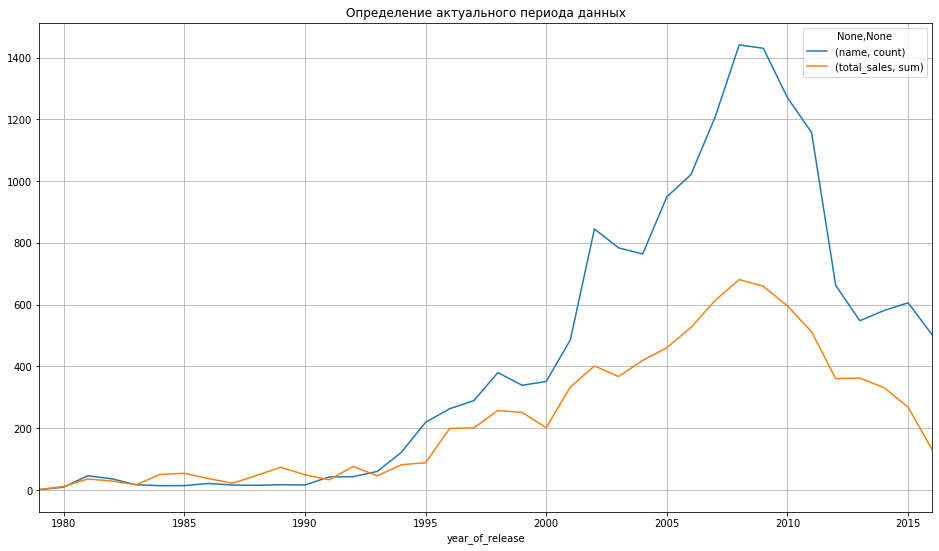

In [ ]:
df_count=df.groupby('year_of_release').agg({'name':['count']})
df_sale=df.groupby('year_of_release').agg({'total_sales':['sum']})
ax=df_count.plot(kind='line', label='game_count')
df_sale.plot(kind='line', label='sum_sales', ax=ax, grid=True, legend=True, figsize=(16,9))
plt.title('Определение актуального периода данных')
plt.show()

- Сам был заядлым геймером на PC, когда-то в 2002 начинал с Героев 3 и Казаков, в период с 2006 по 2011 вышло много замечательных игр, всех и не перечислишь особенно 2008-2010 года были богатыми на хиты (Devil May Cry 4, GTA 4, Assassin's Creed, Mass Effect и многое другое, "я же не хотел перечислять"...).
- C 2012 мы видим отрицательную динамику, это связано с популярностью ММОРПГ таких как L2, WOW, WOT, LoL, Dota, а в последнее время все переходят на мобильный гейминг, и большинство компаний делают ставку именно на смартфоны.
- По выборке видим, что важны данные с 2002, т.к. идет всплеск выпуска новых игр и динамика продаж увеличивается, по выборке с 2002 по 2016 мы сможем найти закономерности делающих игры успешными

### Продажи по платформам

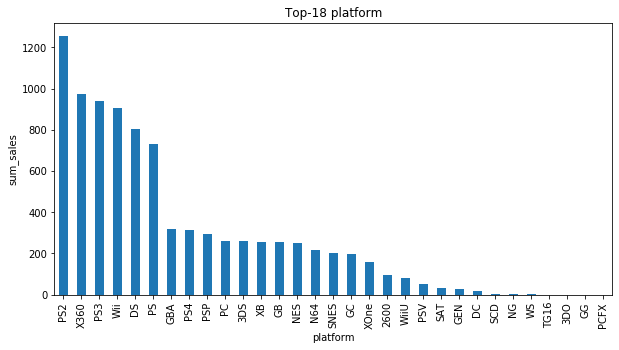

In [ ]:
# выберем ТОП-18 платформ (в них входит родной PC и относительно новые PS4 & XbOne)
play_year = df.groupby('platform').agg({'total_sales':['sum']}).sort_values(by=('total_sales', 'sum'), ascending=False)
play_year.plot(kind='bar', legend=False, figsize=(10,5))
plt.ylabel('sum_sales')
plt.title('Top-18 platform')
plt.show()
# посмотрим 18 платформ, и их жизненный цикл, на следующих шагах отберем современные
our_18 = play_year.loc[:,['platform']].head(18)

- XB One еще имеет скудные продажи, в 2 раза, чем главный конкурент PS4.
- На PC продажи идут скромнее, чем на приставках, скорее всего это связано с пиратством:)
- Взяли 18, чтобы захватить XB One и сравнить все известные платформы

### ТОП платформ с наибольшими суммарными продажами

In [ ]:
top18_pl = df.query("platform in @our_18.index")
top18_pl['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PS4      392
N64      319
XOne     247
SNES     239
GB        98
NES       98
Name: platform, dtype: int64

In [ ]:
# Уберем все что меньше 2002 года
top18_pl = top18_pl.query("year_of_release >= 2002")
top18_pl['platform'].value_counts()
# PC and N64 - не рассматриваем

DS      2128
PS2     1877
PS3     1322
Wii     1302
X360    1254
PSP     1203
PC       909
XB       781
GBA      705
GC       529
3DS      514
PS4      392
XOne     247
PS        23
N64        2
Name: platform, dtype: int64

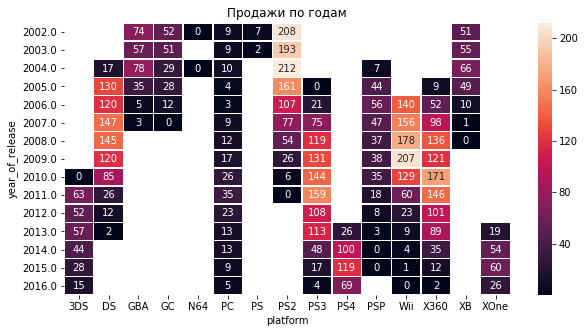

In [ ]:
f, ax= plt.subplots(figsize=(10, 5))
plt.title('Продажи по годам')
sns.heatmap(top18_pl.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc = 'sum'), annot=True, fmt='.0f',linewidths=.5, ax=ax)

Актуальные платформ:
- Nindendo 3DS - портативная платформа, ее обновленные версии покоряют 2020 год;
- PC - бессмертный потенциальный приноситель прибыли, в нынешнее время от ММОРПГ игр, жизненный цикл - это постоянно обновляемое железо;
- PS4, XB One - актуальные платформы, жизненный цикл начат в 2013 году, закончиться примерно в 2023 году, а в РФ наверно и до 2030 будут играть с таким курсом доллара.

Самые прибыльные:
- Х360, PS3, Wii что естественно ввиду постоянной конкурениции, но жизненный цикл уже окончен.

### Жизненный цикл платформ

- не будем отражать распределения следующих платформ, в связи с окончанием цикла и малых продаж: PS, N64, GBA, GC, XB

In [ ]:
pv1=top18_pl.pivot_table(index='year_of_release', columns = 'platform', values='total_sales', aggfunc = 'sum')

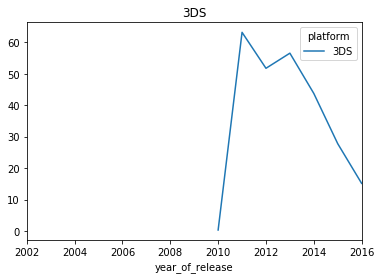

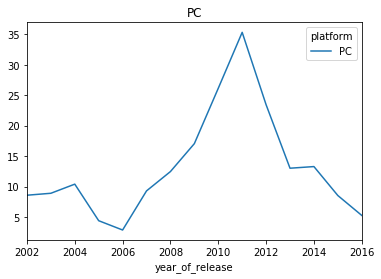

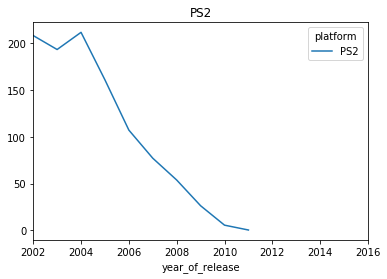

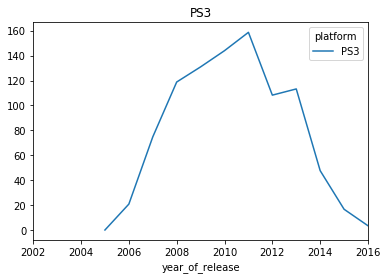

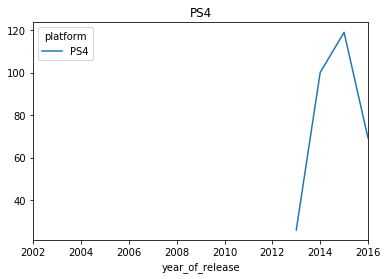

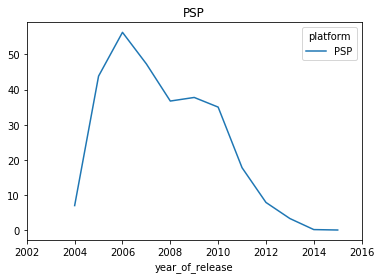

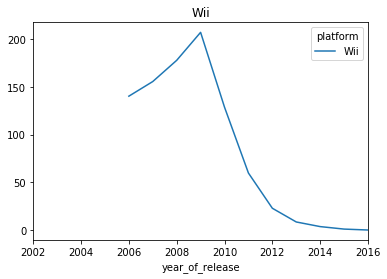

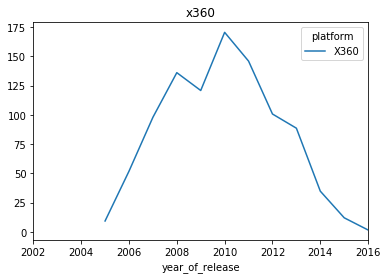

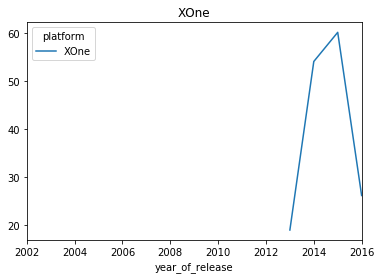

In [ ]:
pv1.loc[:,['3DS']].plot(kind='line')
plt.title('3DS')
plt.show()
pv1.loc[:,['PC']].plot(kind='line')
plt.title('PC')
plt.show()
pv1.loc[:,['PS2']].plot(kind='line')
plt.title('PS2')
plt.show()
pv1.loc[:,['PS3']].plot(kind='line')
plt.title('PS3')
plt.show()
pv1.loc[:,['PS4']].plot(kind='line')
plt.title('PS4')
plt.show()
pv1.loc[:,['PSP']].plot(kind='line')
plt.title('PSP')
plt.show()
pv1.loc[:,['Wii']].plot(kind='line')
plt.title('Wii')
plt.show()
pv1.loc[:,['X360']].plot(kind='line')
plt.title('x360')
plt.show()
pv1.loc[:,['XOne']].plot(kind='line')
plt.title('XOne')
plt.show()

### Вывод:
- Просмотрели платформы, видим, что средний срок жизни платформы 10 лет;
- Только PC живет долго, но не все игры на нем выходят, пик продаж в 2011 году, к 2016 году продажи снизились, во всем виноваты "Танки и смартфоны, мощней, чем мой ноутбук:)";
- 3DS - начало в 2011 году, но продажи резко снижаются, с обновлением модели, вероятно, дела пошли лучше;
- PS2 - жизненный цикл окончен, самая прибыльная платформа - эх, плоечка!;
- PS3 - лидер продаж, жизненный цикл окончен (9-10 лет), пик был в середине, нормальное распределение;
- PS4 - в начале жизн.цикла, прибыль ожидаем в будущих периодах, примерно до 2023;
- Wii - жиз.цикл окончен, одна из прибыльных платформ, давала лучшие результаты, чем PS3 в течении 4 лет жизни, но потом резко сдала, скорее всего не выдержала конкуренцию Xb360 и PS3 - цикл окончен на 8 годах;
- X360 - цикл 11 лет, лидер продаж, нормальное распределение;
- XOne - в начале жизнен. цикла, как и PS4.

### Опеделение актуального периода для прогноза на 2017 год и потенциально прибыльных платформ**

- <font color='purple'>Возьмем актуальный период с 2014 года, исходя из жизненного цикла платформы, и жизненного цикла игр. PS4, XOne, имеют достаточную выборку для решения задачи, а влияние X360 and PS3 спадает.</font>

In [ ]:
# Уберем данные ниже 2014 года, выделим Топ-5
df_1 = top18_pl.query("year_of_release >= 2014")
pv2 = df_1.groupby('platform').agg({'total_sales':['sum']}).sort_values(by=('total_sales', 'sum'), ascending=False)
pv2.head(5) # Top 5

,total_sales
,sum
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22


In [ ]:
top_5 = pv2.loc[:,['platform']].head(5)
top_pl = df_1.query("platform in @top_5.index")

- <font color='purple'>Потенциально прибыльные PS4, XOne, 3DS. PC не является прибыльным для Singl Player, все ушли в "танки играть"..., но зато стабильно идут продажи у компьютера - у него нет жизненного цикла - PC Forever!<font>

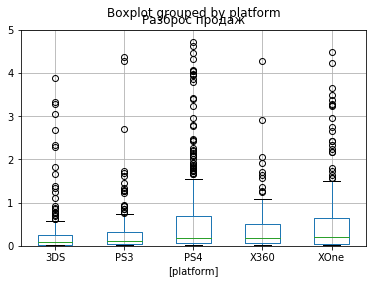

In [ ]:
# Построим ящик с усами
import warnings
warnings.filterwarnings('ignore')
boxplot = top_pl.loc[:,['platform', 'total_sales']] 
boxplot.boxplot(by='platform')
plt.ylim(0,5)
plt.title('Разброс продаж')
plt.show()

### Вывод
- Игр выходит много, среднее и медиана продаж около 0, 75% игр - до 1 млн копий, а вот популярных и хитовых меньше, они и приносят основную прибыль.
- Из них и нужно выбирать, что продавать на следующий год, а также учесть жизненный цикл платформы, если платформе 3-4 года, то следующие года будут потенциально прибыльными. 

- <font color='purple'>Для анализа выбора игр необходимо выбирать из игры с продажей больше 1.5 млн копий и на актуальных платформах, они являются выбросами из общего распределения.<font>

In [ ]:
choice_game=top_pl.query('total_sales >= 1.5')
choice_game.head(10)
# из этого списка и из актуальных платформ нужно выбирать игры.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015.00,Shooter,6.03,5.86,0.36,2.38,nan,nan,unknow,14.63
42,Grand Theft Auto V,PS4,2014.00,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014.00,Role-Playing,4.35,3.49,3.10,0.74,nan,nan,unknow,11.68
77,FIFA 16,PS4,2015.00,Sports,1.12,6.12,0.06,1.28,82.00,4.30,E,8.58
87,Star Wars Battlefront (2015),PS4,2015.00,Shooter,2.99,3.49,0.22,1.28,nan,nan,unknow,7.98
92,Call of Duty: Advanced Warfare,PS4,2014.00,Shooter,2.81,3.48,0.14,1.23,83.00,5.70,M,7.66
94,FIFA 17,PS4,2016.00,Sports,0.66,5.75,0.08,1.11,85.00,5.00,E,7.60
96,Super Smash Bros. for Wii U and 3DS,3DS,2014.00,Fighting,3.27,1.37,2.43,0.48,nan,nan,unknow,7.55
99,Call of Duty: Black Ops 3,XOne,2015.00,Shooter,4.59,2.11,0.01,0.68,nan,nan,unknow,7.39
105,Fallout 4,PS4,2015.00,Role-Playing,2.53,3.27,0.24,1.13,87.00,6.50,M,7.17


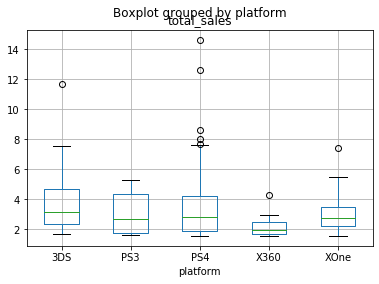

In [ ]:
choice_game.boxplot(column='total_sales',by='platform')

### Влияние отзывов на продажи внутри платформы

- <font color='purple'>Подготовим данные для определения взаимосвязи.<font>

In [ ]:
x1=top_pl.query("platform == 'XOne'")
x1=x1.loc[:,['critic_score', 'user_score', 'total_sales']]
ps4=top_pl.query("platform == 'PS4'")
ps4=ps4.loc[:,['critic_score', 'user_score', 'total_sales']]
N3ds=top_pl.query("platform == '3DS'")
N3ds=N3ds.loc[:,['critic_score', 'user_score', 'total_sales']]

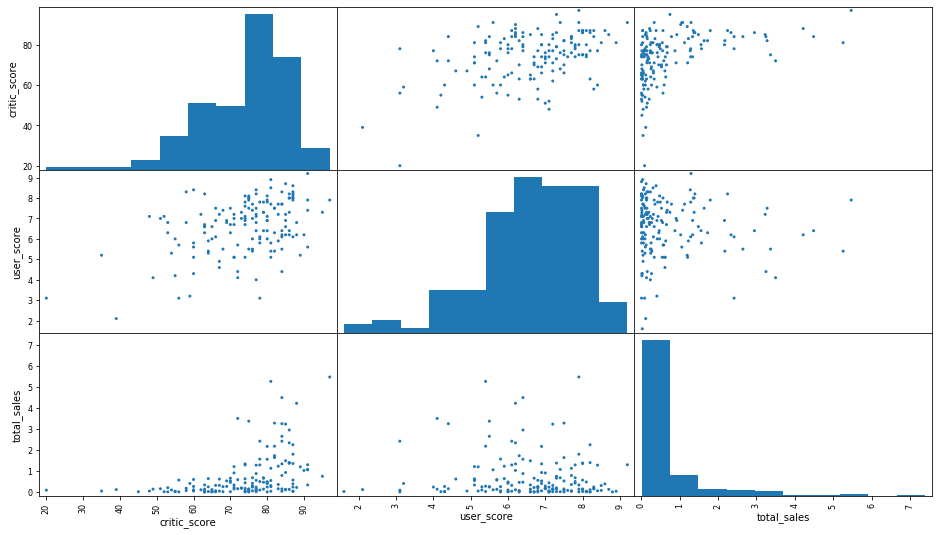

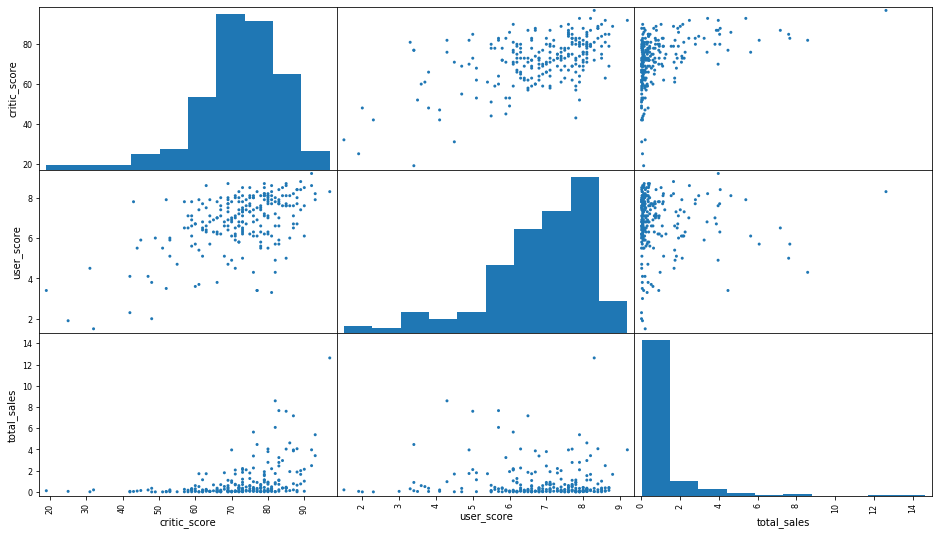

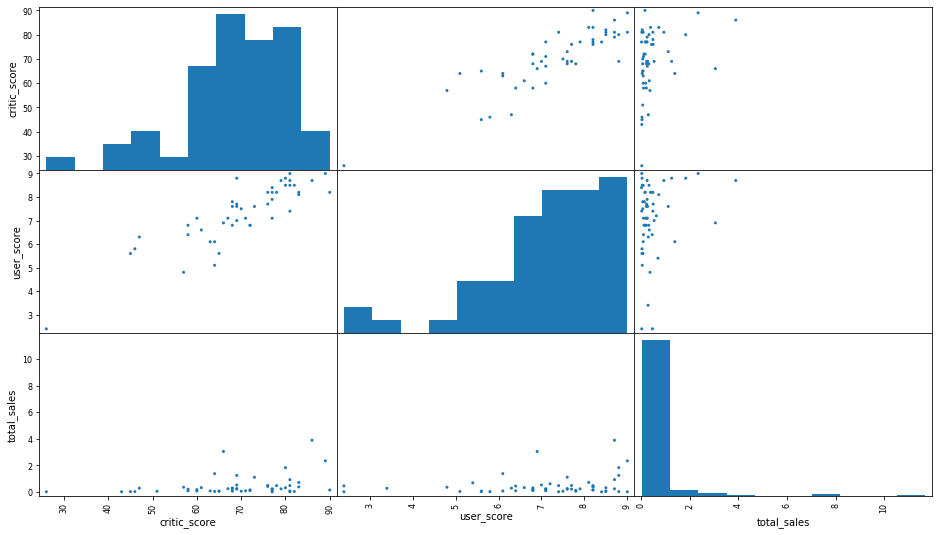

In [ ]:
# Проверим корреляцию
scatter = [x1, ps4, N3ds]
for i in scatter:
    pd.plotting.scatter_matrix(i, figsize=(16, 9), alpha=1)
    plt.show()

In [ ]:
for i in scatter:
    display(i.corr())

,critic_score,user_score,total_sales
critic_score,1.00,0.44,0.43
user_score,0.44,1.00,-0.07
total_sales,0.43,-0.07,1.00


,critic_score,user_score,total_sales
critic_score,1.00,0.55,0.40
user_score,0.55,1.00,-0.04
total_sales,0.40,-0.04,1.00


,critic_score,user_score,total_sales
critic_score,1.00,0.86,0.31
user_score,0.86,1.00,0.22
total_sales,0.31,0.22,1.00


**Вывод**
- Есть прямая взаимосвязь между отзывами критиков и пользователей;
- Взаимосвязь между отзывами и продажами низкая, т.к. основная выборка имеет продажи меньше 1 млн. копий, много игр имеет небольшое кол-во продаж, но высокие оценки;
- Но практически все игры, имеющие высокие продажи, имеют высокие оценки критиков;
- На других платформах взаимосвязь примерно такая же, на Nindendo ниже.

### Распределение жанров по продажам

In [ ]:
top_pl.groupby('genre').agg({'total_sales':['sum','mean']}).sort_values(by=('total_sales','mean'), ascending=False)

total_sales     
                     sum mean
genre                        
Shooter           159.68 1.55
Sports            105.88 0.78
Role-Playing       88.95 0.64
Fighting           21.55 0.44
Platform           10.97 0.42
Action            175.17 0.42
Racing             19.69 0.38
Misc               26.32 0.35
Simulation          6.49 0.28
Adventure          14.47 0.15
Puzzle              0.93 0.10
Strategy            1.49 0.09

**Выводы**
- Акшены и шутеры в первых рядах, спорт (наверняка PES, FIFA, NHL), а вот стратегии на самом последнем месте (незаслужено, я фанат Героев 3 и СтарКрафта2), RPG один из популярных жанров в РФ только на 5 месте в Мире.
- <font color='purple'>Средний чек по играм распределил фаворитов по другим местам: шутер и спорт переместились на ступеньку повыше, экшен упал на 6 место, стратегии, к сожалению, не поднялись выше.</font>

## Портрет пользователя каждого региона
1. Определим для пользователя каждого региона (NA, EU, JP):
    - Самые популярные платформы (топ-5);
    - Самые популярные жанры (топ-5);

In [ ]:
na_s=top_pl.pivot_table(index='platform', values = 'na_sales', aggfunc = 'sum').sort_values(by=('na_sales'), ascending=False).head()
display(na_s / na_s.sum())

,na_sales
platform,
PS4,0.39
XOne,0.32
X360,0.11
3DS,0.09
PS3,0.09


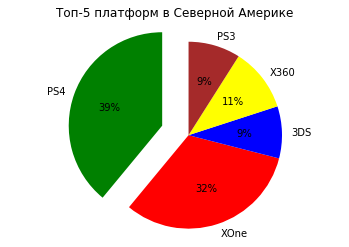

In [ ]:
na_s.plot.pie
labels = ['PS4','XOne','3DS','X360','PS3']
values = [39,32,9,11,9]
colors = ['green','red','blue','yellow','brown']
explode = [0.3,0,0,0,0]
plt.title('Топ-5 платформ в Северной Америке')
plt.pie(values,labels=labels,colors=colors,explode=explode,autopct='%1.0f%%',startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
eu_s=top_pl.pivot_table(index='platform', values = 'eu_sales', aggfunc = 'sum').sort_values(by=('eu_sales'), ascending=False).head()
display(eu_s / eu_s.sum())

,eu_sales
platform,
PS4,0.56
XOne,0.20
PS3,0.11
3DS,0.07
X360,0.07


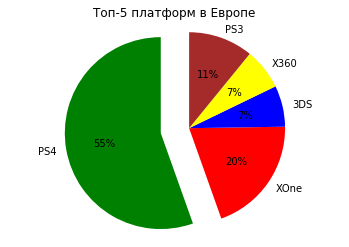

In [ ]:
eu_s.plot.pie
labels = ['PS4','XOne','3DS','X360','PS3']
values = [56,20,7,7,11]
colors = ['green','red','blue','yellow','brown']
explode = [0.3,0,0,0,0]
plt.title('Топ-5 платформ в Европе')
plt.pie(values,labels=labels,colors=colors,explode=explode,autopct='%1.0f%%',startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
jp_s=top_pl.pivot_table(index='platform', values = 'jp_sales', aggfunc = 'sum').sort_values(by=('jp_sales'), ascending=False).head()
display(jp_s / jp_s.sum())

,jp_sales
platform,
3DS,0.62
PS4,0.21
PS3,0.16
XOne,0.00
X360,0.00


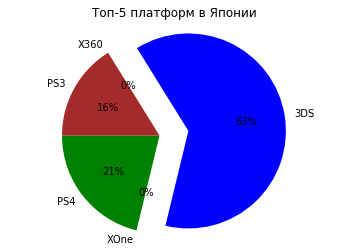

In [ ]:
jp_s.plot.pie
labels = ['PS4','XOne','3DS','X360','PS3']
values = [21,0,62,0,16]
colors = ['green','red','blue','yellow','brown']
explode = [0,0,0.3,0,0]
plt.title('Топ-5 платформ в Японии')
plt.pie(values,labels=labels,colors=colors,explode=explode,autopct='%1.0f%%',startangle=180)
plt.axis('equal')
plt.show()

**Выводы**
- <font color='purple'>Хотя платформы вышли в один год, но пальму первенства в Европе и в Америке занимает PS4, даже в США продукт Micsrosoft уступает;</font>
- Япония удивляет своим подходом, я думал PS4, а оказалось Nindendo, а также в лидерах портативные платформы.
- По оценкам экспертов 3DS в последнее время стала делать достойные продукты в 3D без стереоочков, она портативна, т.к. многие переходят на игры в смартфонах.
- И Япония начисто недолюбливает Xbox, зачем покупать импорт, если отечественный производитель выпускает лучше!

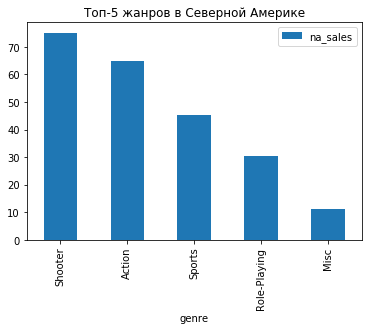

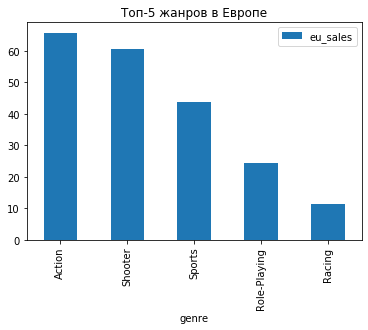

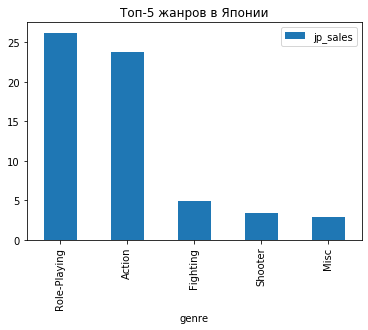

In [ ]:
top_pl.pivot_table(index='genre', values = 'na_sales', aggfunc = 'sum').sort_values(by=('na_sales'), ascending=False).head().plot(kind='bar')
plt.title('Топ-5 жанров в Северной Америке')
plt.show()
top_pl.pivot_table(index='genre', values = 'eu_sales', aggfunc = 'sum').sort_values(by=('eu_sales'), ascending=False).head().plot(kind='bar')
plt.title('Топ-5 жанров в Европе')
plt.show()
top_pl.pivot_table(index='genre', values = 'jp_sales', aggfunc = 'sum').sort_values(by=('jp_sales'), ascending=False).head().plot(kind='bar')
plt.title('Топ-5 жанров в Японии')
plt.show()

**Выводы**
- Японцы молодцы, РПГ на 1 месте, конечно же, много РПГ с мировым именем созданы в Азии, а вот шуттеров вообще нет в Топ-5;
- Видим какая разница в интересах, Европа и Америка любители экшена, спорта и шуттеров, также европейцы - любители погонят, скорее всего немцы;
- Стратегий тут нет:( - не каждый захочет часами сидеть, чтобы победить противника, всем хочется зайти, получить эмоции и выйти, вот почему сейчас так популярны мобильные игры на смартфонах, как раз Экшен и Шутер PUBG & Fortnite. 

2. Влияние рейтинг ESRB на продажи в регионе<a id="esrb"></a>

In [ ]:
x=top_pl.pivot_table(index='rating', values = 'na_sales', aggfunc = 'sum').sort_values(by=('na_sales'), ascending=False)
y=top_pl.pivot_table(index='rating', values = 'eu_sales', aggfunc = 'sum')
z=top_pl.pivot_table(index='rating', values = 'jp_sales', aggfunc = 'sum')
ESRB = x.merge(y, on='rating', how = 'outer')

ESRB=ESRB.merge(z, on='rating', how = 'outer')
display(ESRB)

,na_sales,eu_sales,jp_sales
rating,,,
M,98.66,93.43,7.63
unknow,49.51,41.73,43.56
E,42.42,49.64,5.51
T,35.69,29.29,11.50
E10+,26.59,19.35,2.68


In [ ]:
# метод корреляции spearman
top_pl['na_sales'].corr(top_pl['rating'], method='spearman')

-0.37170466605009905

In [ ]:
top_pl['eu_sales'].corr(top_pl['rating'], method='spearman')

-0.3902471857519776

In [ ]:
top_pl['jp_sales'].corr(top_pl['rating'], method='spearman')

0.34957189005615724

### Вывод
- <font color='purple'>Рынок Америки самый емкий: основная доля игры для взрослых, но и большая доля игр для всех, далее идет молодеж;
- Рынок Европы имеет меньше продаж, но интересы те же;
- Рынок Японии - имеет самую большую взаимосвязь с возрастным рейтингом: Игры больше ориентировны на молодежь, а потом уже на взрослых и игры для всех;
- Европа и америка ориентирована на взрослых, Япония на молодеж и мобильный гейминг.</font>

## Проверьте гипотезы

***Первая гипотеза***, которую нужно проверить:

Формулировка двухсторонних гипотез заключается в том, что нулевая гипотеза должна иметь знак равенства:
- H₀: Средние пользовательские рейтинги платформ Xbox One и PC равны.
- H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются;

Чтобы проверить гипотезу о равенстве/неравенстве среднего двух выборок применим метод scipy.stats.ttest_ind (array1, array2, equal_var) .

<font color='purple'>Подготовим данные<font>

In [ ]:
df_1['user_score'] = df_1['user_score'].fillna(0) # Тест Левене не идет без удаление Нан
df_x1 = df_1.query("platform == 'XOne'")
df_pc = df_1.query("platform == 'PC'")

In [ ]:
# сравним дисперсии методом Левене, чтобы понять какой параметр equal_var указывать
sample_1=df_x1['user_score'].tolist()
sample_2=df_pc['user_score'].tolist()
stat, p = levene(sample_1, sample_2)
p

0.30666684786878545

In [ ]:
# Дополнительно сравним дисперсии
[np.var(x, ddof=1) for x in [df_x1['user_score'], df_pc['user_score']]]

[10.100598771156967, 8.536739072847682]

- Выборки неоднородны примем equal = False

In [ ]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем нулевую гипотезу
results = st.ttest_ind(sample_1, sample_2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.31981092459798116
Не получилось отвергнуть нулевую гипотезу


### Вывод
- Полученное значение p-value не отвергает нулевую гипотезу и говорит о том, что с вероятностью в почти <font color='purple'>31%<font> такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними.

***Вторая гипотеза***, которую нужно проверить:

Формулировка двухсторонних гипотез заключается в том, что нулевая гипотеза должна иметь знак равенства:
- H₀: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») равны.
- H₁: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные;

Чтобы проверить гипотезу о равенстве/неравенстве среднего двух выборок применим метод scipy.stats.ttest_ind (array1, array2, equal_var).

In [ ]:
# Подготовим данные по жанрам
df_act=df_1.query("genre == 'Action'")
df_sp=df_1.query("genre == 'Sports'")
# сравним дисперсии методом Левене, чтобы понять какой параметр equal_var указывать
from scipy.stats import levene
sample1=df_act['user_score'].tolist()
sample2=df_sp['user_score'].tolist()
stat, p = levene(sample1, sample2)
p

5.0201250626260846e-29

In [ ]:
# Дополнительно сравним дисперсии
[np.var(x, ddof=1) for x in [df_act['user_score'], df_sp['user_score']]]

[12.09533244347296, 6.787348993288591]

<font color='purple'>Дисперсии выборок не равны, возьмем equal_val=False<font>

In [ ]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем нулевую гипотезу
results = st.ttest_ind(sample1, sample2, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0038830239075224714
Отвергаем нулевую гипотезу


### Вывод
- Полученное значение p-value отвергает нулевую гипотезу H₀. Это говорит о том, что средние отзывы жанров с большой вероятностью различны и нельзя сказать о их равенстве.

## Общий вывод

- Основной всплеск компьютерных игр начался с 2002 года, с 2012 мы видим отрицательную динамику, это связано с популярностью ММОРПГ, а в последнее время все переходят на мобильный гейминг, и большинство компаний делают ставку именно на смартфоны;
- Средний срок жизни платформы 10 лет;

Актуальные платформ:
- Nindendo 3DS;
- PC - бессмертный потенциальный приноситель прибыли, в нынешнее время от ММОРПГ игр;
- PS4, XB One - актуальные платформы, жизненный цикл начат в 2013 году, закончиться примерно в 2023 году, а в РФ наверно и до 2030 будут играть с таким курсом доллара;

Самые прибыльные:
- Х360, PS3, Wii что естественно ввиду постоянной конкурениции, но жизненный цикл уже окончен.

Динамика продаж:
- Возьмем за базу Х360 и PS3 - это лидеры, также лидер Wii (но жизненный цикл приставок подошел к концу и продажи игр снизились до минимальных значений, либо уже их нет);
- А как потенциально прибыльные PS4, XOne, 3DS. PC не является прибыльным для Singl Player, все ушли в "танки играть"..., но зато стабильно идут продажи у компьютера - у него нет жизненного цикла - PC Forever!

Общее резюме по играм:
- Игр выходит много, 75% игр - с продажами до 1 млн копий, а вот популярных и хитовых меньше, они и приносят основную прибыль.
- Из игр, которые являются выбросами на диаграмме размаха и нужно выбирать потенциально прибыльные игры, либо их продолжения, также учесть жизненный цикл платформы, если платформе 3-4 года, то следующие года будут потенциально прибыльными.
- Взаимосвязь между отзывами и продажами низкая, т.к. основная выборка имеет продажи меньше 1 млн. копий, много игр имеет небольшое кол-во продаж, но высокие оценки;
- Но практически все игры, имеющие высокие продажи, имеют высокие оценки критиков;

Жанры:
- В мире: Акшены, спорт, шутеры в первых рядах, а вот стратегии на самом последнем месте, RPG один из популярных жанров в РФ только на 5 месте в Мире;
- В Японии, РПГ на 1 месте, конечно же, много РПГ с мировым именем созданы в Азии, а вот шуттеров вообще нет в Топ-5 (пацифисты);
- Видим какая разница в интересах, Европа и Америка любители экшена, спорта и шуттеров, также европейцы - любители погонят, скорее всего немцы;
- Стратегий тут нет:( - не каждый захочет часами сидеть, чтобы победить противника, всем хочется зайти, получить эмоции и выйти, вот почему сейчас так популярны мобильные игры на смартфонах, как раз Экшен и Шутер PUBG & Fortnite.

<font color='purple'>Распределение платформ:
- В США и в Европе - пальму первенства занимает PS4, в Японии - портативная Nindendo 3DS, PS4 и PS3 идут следом, а вот продукция Microsoft в Японии не ценится;

Возрастной рейтинг:
- Рынок Америки самый емкий: основная доля игры для взрослых, но и большая доля игр для всех, далее идет молодеж;
- Рынок Европы имеет меньше продаж, но интересы те же;
- Рынок Японии - имеет самую большую взаимосвязь с возрастным рейтингом: Игры больше ориентировны на молодежь, а потом уже на взрослых и игры для всех;
- Европа и америка ориентирована на взрослых, Япония на молодеж и мобильный гейминг.<font>